In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir) 
print("Appended base directory", base_dir)

# Import external libraries
from lib.numerics.integrator_lib import integrate_ode_ord1

Appended base directory /home/alyosha/work/snippets-data-analysis/python/


### Problem:
Continuity equation is given by $\partial_t \psi(x,t) + \partial_x j(x,t) = 0$. According to Fick's law, the flux of particles $j(x,t) = D \partial_x \psi(x,t)$. Combining them together gives the 1D uniform diffusion equation

$\partial_t \psi(t,x) = D \partial_x^2 \psi(t,x)$

Solve equation given initial conditions

$\psi(0, x) = \psi_0(x)$

Impenetrable wall boundary conditions are given by

$J(x, t) = 0 \;\; \forall x \notin [0, 1]$

# 1. Discretization - FDTD

Using 2nd order central differences to discretize space, we arrive at

$ \partial_t \psi(t,x) = D \frac{\psi(t, x+\Delta x) - 2\psi(t, x) + \psi(t, x-\Delta x)}{\Delta x^2} $

This equation can be rewritten in vector form, using index to denote spatial discretization nodes

$ \partial_t \psi_i(t) = \frac{D}{\Delta x^2} \sum_{j=1}^n M_{ij} \psi_j(t)$

where the 3-diagonal matrix is given by

$M_{ij} = \delta_{i,j+1} - 2\delta_{i,j} + \delta_{i,j-1}$

The boundary condition is given by $J_0(t) = \frac{D}{\Delta x} (\psi_1 - \psi_0) = 0$, and thus $\psi_1 = \psi_0$. There is no need to have 2 DoF that are exactly equivalent to each other, therefore we can use this equation to modify the the equation for $\psi_1$

$ \partial_t \psi_1 = \frac{D}{\Delta x^2} (\psi_0 - 2\psi_1 + \psi_2) = \frac{D}{\Delta x^2} (\psi_2 - \psi_1)$

Applying the same logic to the other boundary analogously, we obtain the boundary conditions

$
\begin{eqnarray}
  \partial_t \psi_0 &=& \frac{D}{\Delta x^2} (\psi_2 - \psi_1)\\
  \partial_t \psi_n &=& \frac{D}{\Delta x^2} (\psi_{n-1} - \psi_n)
\end{eqnarray}
$

which allow us to correctly adjust the first and the last row of the matrix

$
\begin{eqnarray}
  M_{1j} &=& -\delta_{1, j} + \delta_{2, j}\\
  M_{nj} &=& \delta_{n-1, j} - \delta_{n, j}
\end{eqnarray}
$


### Discretization - FDTD - 1st order time
On top of that, using 1st order in time, we get

$\psi_i(t+\Delta t) = \psi_i(t) + \zeta \sum_{j=1}^n M_{i,j} \psi_j(t)$

where $\zeta = \frac{2 D \Delta t}{\Delta x^2}$

Von Neumann stability analysis can be applied to show that $\Delta x$ and $\Delta t$ must be selected in such a way that $\zeta < 1$, otherwise the system is unstable and the errors blow up

### Conclusions - FDTD:
* The particle quantity appears to be conserved
* The eigenbasis looks like Fourier series - they should be the optimal basis for solving this problem


Solving discretized diffusion equation using parameters {
    "D": 1.0,
    "dx": 0.001,
    "dt": 0.001,
    "eta": 1000000.0,
    "zeta": 1000.0,
    "T": 0.1,
    "nx": 1000,
    "nt": 100
}
Conservation of mass self-test: initial density 0.5 final density 0.499999999999993
Imaginary part of eigenvectors 0.0


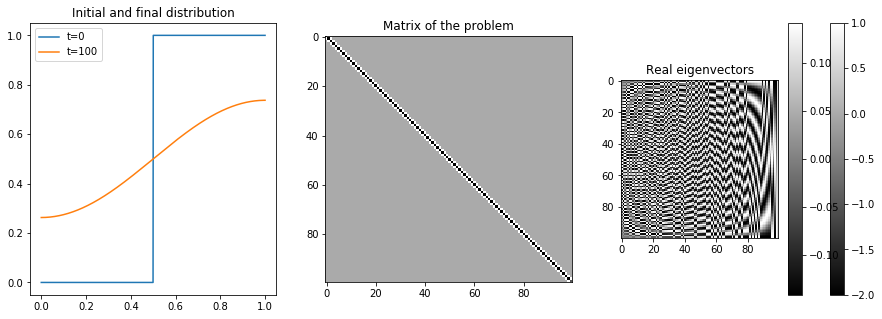

In [3]:
############################################
# Setup
############################################

param = {}

param['D'] = 1.0
param['dx'] = 0.001
#param['dt'] = 0.25 * param['dx']**2 / param['D']    # 0.5 * dx**2 / D is the VonNeumann Stability bound
param['dt'] = 0.001  # For scipy time-discretization we don't need VonNeumann Stability
param['eta'] = param['D'] / (param['dx']**2)
param['zeta'] = param['eta'] * param['dt']
param['T'] = 0.1
param['nx'] = int(1 / param['dx'])
param['nt'] = int(param['T'] / param['dt'])

print()
print("Solving discretized diffusion equation using parameters", json.dumps(param, indent = 4))

def initState(nx):
    x = np.linspace(0, 1, nx)
    y = np.array([int(xval > 0.5) for xval in x])
#     y = np.exp(-(x - 0.5)**2/(2 * 0.02)) / np.sqrt(2 * np.pi * 0.02)
    return x, y

# Compute Matrix-vector product M*psi, which is RHS of the PDE up to a constant
def update_mv(uthis):
    rez = np.zeros(len(uthis))
    rez[1:-1] = uthis[:-2] - 2.0*uthis[1:-1] + uthis[2:]
    rez[0] = uthis[1] - uthis[0]
    rez[-1] = uthis[-2] - uthis[-1]
    
    return rez
    
def update_ord1(uthis, param):
    return uthis + param['zeta'] * update_mv(uthis)

############################################
# Solve
############################################

# Initial state
x,y = initState(param['nx'])

# Run simulation - 1st order in time
# uthis = copy.deepcopy(y)
# for i in range(param['nt']):
#     uthis = update_ord1(uthis, param)

# Run simulation - fancy forwards-integrator
rhs = lambda var, t: update_mv(var) * param['eta']
rez = integrate_ode_ord1(rhs, y, param['dt'], param['nt'], method='scipy')
uthis = rez[-1] # Only care about the last result at the moment

print("Conservation of mass self-test: initial density", np.sum(y)/param['nx'], "final density", np.sum(uthis)/param['nx'])

############################################
# Investigate eigenvectors of the matrix
############################################

MATSIZE = 100
M = np.zeros((MATSIZE, MATSIZE))
M[0, :2] = np.array([-1.0, 1.0])
M[-1, -2:] = np.array([1.0, -1.0])
for i in range(1, MATSIZE-1):
    #M[i, i-1:i+2] = np.array([0.5, 0.25, 0.5])
    M[i, i-1:i+2] = np.array([1.0, -2.0, 1.0])

evals, evecs = np.linalg.eig(M.T)
idxsort = np.argsort(evals)

############################################
# Results
############################################

print("Imaginary part of eigenvectors", np.max(np.abs(np.imag(evecs[:, idxsort]))))

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(x, y, label="t=0")
ax[0].plot(x, uthis, label="t="+str(param['nt']))
map1 = ax[1].imshow(M, cmap='gray')
map2 = ax[2].imshow(np.real(evecs[:, idxsort]), cmap='gray')

ax[0].legend()
fig.colorbar(map1)
fig.colorbar(map2)

ax[0].set_title("Initial and final distribution")
ax[1].set_title("Matrix of the problem")
ax[2].set_title("Real eigenvectors")

plt.show()

# 2. Discretization - FEM - p-refinement

Define inner product as $\langle u | v \rangle = \int_0^1 u(x)v(x)dx$

The weak-form of the original PDE is an integral of the PDE tested with an arbitrary test function $u(x)$

$\langle u | \partial_t \psi \rangle = D \langle u | \partial_x^2 \psi \rangle$

Integrating the RHS by parts we obtain

$\langle u | \partial_t \psi \rangle = D (u \partial_x \psi|_1 - u \partial_x \psi|_0 - \langle \partial_x u | \partial_x \psi \rangle)$

According to the wall boundary condition, the gradient of particle density is zero at the boundary, so we get

$\langle u | \partial_t \psi \rangle = -D \langle \partial_x u | \partial_x \psi \rangle$

To discretize the problem, we expand the density using truncated series $\psi(x,t) = \sum_{i=1}^n a_i(t) \beta_i(x)$. Further, according to Galerkin's approach, we select a finite set of testing functions that is the same as the basis functions of the series expansion. We thus obtain an ODE for the series expansion coefficients

$\sum_{j=1}^n M_{ij} \partial_t a_j = -D \sum_{j=1}^n N_{ij} a_j$

where $M_{ij} = \langle \beta_i | \beta_j \rangle$ and $N_{ij} = \langle \partial_x \beta_i | \partial_x \beta_j \rangle$

This equation can be solved by picking an arbitrary finite basis and solving a linear system for each time step to find the values of $a_i$. However, a well-chosen basis can reduce a lot of work.  Choosing an orthonormal basis sets $M_{ij}$ to the identity matrix. Further, using the Fourier basis $\beta_i(x) = exp(j\omega_i x)$ also sets the $N_{ij}$ matrix to a diagonal form, namely $N_{ij} = \omega_i^2 \delta_{ij}$, resulting in a final equation

$\partial_t a_i = -D \omega_i^2 a_i$

From this equation it is immediately obvious that all Fourier harmonics will decay exponentially, except of the constant $\omega_0 = 0$, which will remain unchanged, and the final solution will be the constant fit to the initial conditions, which is the average particle quantity, as expected.

Finally, using the properties of the orthonormal functions, the initial values of the expansion coefficients can be found via

$a_i(t = 0) = \langle \beta_i | \psi_0 \rangle$

The final solution at time $t$ can be reconstructed from the expansion coefficients using the already-mentioned expansion formula

$\psi(x,t) = \sum_{i=1}^n a_i(t) \beta_i(x)$

# 3. Discretization - FEM - h-refinement

The second trick of of FEM is using basis functions of small support, thus covering the domain with slightly overlapping patches. The logic is very similar to FDTD. The advantage over FDTD is that the patches can be of arbitrary size, allowing to adaptively refine finer structures and coarsen the space where nothing much happens. Also, in 2D and 3D the patches allow for smooth edges, significantly decreasing the discretization errors appearing in FDTD. However, the disadvantage is the requirement to construct triangulations of geometries and use connectivity graphs to find neighbours of each finite element. Thus, FEM with h-refinement requires a significantly more complicated code and more human input for setup, but can gain significant accuracy/performance enhancement and reduction of memory footprint over other methods. As such, it is only superior to other methods for very large problems, where linear systems of sufficient accuracy employed by other methods simply do not fit into computer's memory.

For this scenario, we will discretize the domain into $n$ boxes of size $\Delta x$ each, and employ "house" basis functions

$
\begin{eqnarray}
  \beta_i(x) &=& \frac{x-(i-1)\Delta x}{\Delta x} \;\; \forall x \in [(i-1)\Delta x, i\Delta x]\\
  \beta_i(x) &=& 1 - \frac{(x - i\Delta x)}{\Delta x} \;\; \forall x \in [i\Delta x, (i+1)\Delta x]
\end{eqnarray}
$

Its derivative is thus

$
\begin{eqnarray}
  \beta_i(x) =& \frac{1}{\Delta x} \;\; & \forall x \in [(i-1)\Delta x, i\Delta x)\\
  \beta_i(x) =& -\frac{1}{\Delta x} \;\; & \forall x \in (i\Delta x, (i+1)\Delta x] \\
  \beta_i(x) =& 0 \;\; & \forall x = i\Delta x
\end{eqnarray}
$